In [1]:
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from empath import Empath
from scipy.sparse import hstack
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import pandas as pd
from scipy.sparse import csr_matrix
import nltk
import re
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
import argparse
from sklearn.metrics import f1_score
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import spacy
from finalproj_fns import *
from sklearn.model_selection import RandomizedSearchCV
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score
import torch
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss


c:\Users\lilil\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
crowd_data = load_csv("./crowd_train.csv")
post_data = load_csv("./shared_task_posts.csv")
crowd_test = load_csv("./crowd_test.csv")
post_test = load_csv("./shared_task_posts_test.csv")
# process training set
data_for_prediction = data_process(post_data, crowd_data)

# process test set
data_for_test = data_process(post_test, crowd_test, train=False)

length of training set: 31495
empty label:  0
length of test set: 9588
empty label:  0


In [3]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'label' column in data_for_prediction
data_for_prediction['label_encoded'] = label_encoder.fit_transform(data_for_prediction['label'])

# Check the encoded labels
print(data_for_prediction['label_encoded'].unique())


[0 2 3 1]


In [5]:
# Define a function to tokenize and encode the texts
def tokenize_and_encode(texts, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

# Tokenize the 'combined_text' column
input_ids, attention_masks = tokenize_and_encode(data_for_prediction['combined_text'], tokenizer)

# Print the shapes of the resulting tensors
print("Input IDs shape:", input_ids.shape)
print("Attention Masks shape:", attention_masks.shape)

c:\Users\lilil\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Input IDs shape: torch.Size([31495, 128])
Attention Masks shape: torch.Size([31495, 128])


In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train_ids, X_val_ids, X_train_masks, X_val_masks, y_train, y_val = train_test_split(
    input_ids, attention_masks, data_for_prediction['label_encoded'], 
    test_size=0.2, random_state=42
)

# Print the shapes of the resulting sets
print("Training input IDs shape:", X_train_ids.shape)
print("Validation input IDs shape:", X_val_ids.shape)
print("Training attention masks shape:", X_train_masks.shape)
print("Validation attention masks shape:", X_val_masks.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)


Training input IDs shape: torch.Size([25196, 128])
Validation input IDs shape: torch.Size([6299, 128])
Training attention masks shape: torch.Size([25196, 128])
Validation attention masks shape: torch.Size([6299, 128])
Training labels shape: (25196,)
Validation labels shape: (6299,)


In [7]:
# Define the BERT model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',  # Use the 12-layer BERT model, with an uncased vocab.
    num_labels=4,         # The number of output labels for the classification task.
    output_attentions=False,  # Whether the model returns attentions weights.
    output_hidden_states=False,  # Whether the model returns all hidden-states.
)

# Print the model structure
print(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [26]:
from transformers import get_linear_schedule_with_warmup

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Define the total number of training steps
epochs = 10
total_steps = len(X_train_ids) // 16 * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,  # Default value in run_glue.py
    num_training_steps=total_steps
)

# Print the optimizer and scheduler
print(optimizer)
print(scheduler)


AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 2e-05
    lr: 2e-05
    maximize: False
    weight_decay: 0.01
)


In [9]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Move the model to the GPU.
model.to(device)

# Move the training data to the GPU.
X_train_ids = X_train_ids.to(device)
X_train_masks = X_train_masks.to(device)
X_val_ids = X_val_ids.to(device)
X_val_masks = X_val_masks.to(device)
y_train, y_val = torch.tensor(y_train.values, dtype=torch.long).to(device), torch.tensor(y_val.values, dtype=torch.long).to(device)

# Print device being used
print(f'Using device: {device}')


Using device: cuda


In [10]:
# Print types and shapes to debug the issue
print("X_train_ids type:", type(X_train_ids), "shape:", X_train_ids.shape)
print("X_train_masks type:", type(X_train_masks), "shape:", X_train_masks.shape)
print("y_train type:", type(y_train), "shape:", y_train.shape)


X_train_ids type: <class 'torch.Tensor'> shape: torch.Size([25196, 128])
X_train_masks type: <class 'torch.Tensor'> shape: torch.Size([25196, 128])
y_train type: <class 'torch.Tensor'> shape: torch.Size([25196])


In [11]:
# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(X_train_ids, X_train_masks, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(X_val_ids, X_val_masks, y_val)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [12]:
# Training loop
epochs = 10
loss_fn = CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_labels = batch

        # Clear previously calculated gradients
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch)
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the optimizer
        optimizer.step()

        # Update the learning rate
        scheduler.step()

        # Accumulate the training loss
        total_loss += loss.item()
# Print training progress
    if (epoch + 1) % epochs == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
    

Epoch [10/10], Loss: 0.6344


In [13]:
avg_train_loss = total_loss / len(train_dataloader)
print(f"Average training loss for epoch {epoch}: {avg_train_loss}")

Average training loss for epoch 9: 0.6782736493954583


In [14]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
# Evaluate on validation set
model.eval()
val_loss = 0
all_preds = []
all_labels = []
for batch in val_dataloader:
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = b_input_ids.to(device)
    b_input_mask = b_input_mask.to(device)
    b_labels = b_labels.to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        val_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(b_labels.cpu().numpy())

avg_val_loss = val_loss / len(val_dataloader)
print(f"Average validation loss: {avg_val_loss}")

# Calculate F1 score
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"F1 Score: {f1}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(f"Confusion Matrix:\n{conf_matrix}")

Average validation loss: 1.0684069990355352
F1 Score: 0.5124298383325877
Confusion Matrix:
[[1336   56  173  569]
 [ 150  141   64  202]
 [ 277   33  450  410]
 [ 427   41  207 1763]]


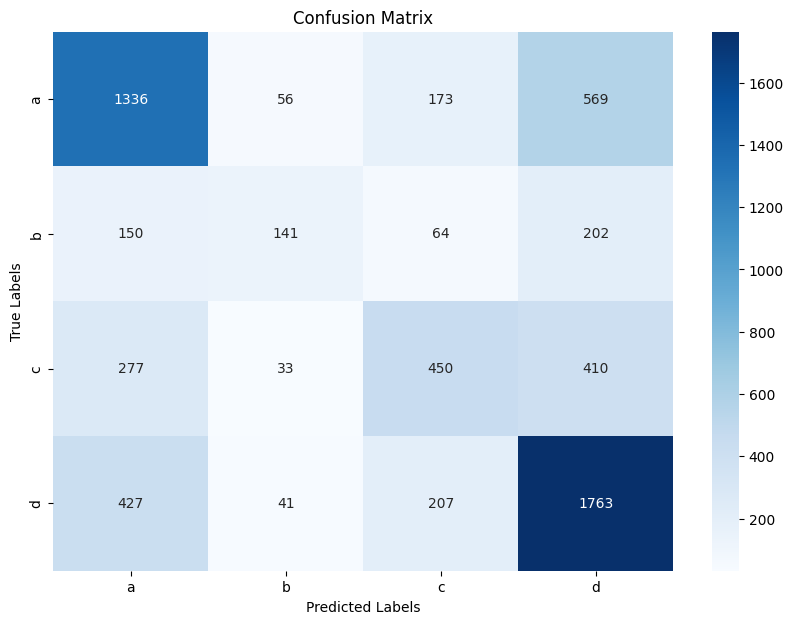

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot confusion matrix
class_names = ['a', 'b', 'c','d']
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# process test dataset

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'label' column in data_for_prediction
data_for_test['label_encoded'] = label_encoder.fit_transform(data_for_test['raw_label'])
y_test = data_for_test['label_encoded']
# Check the encoded labels
print(data_for_test['label_encoded'].unique())

[2 0 3 1]


In [19]:
# Tokenize the 'combined_text' column
test_input_ids, test_attention_masks = tokenize_and_encode(data_for_test['combined_text'], tokenizer)

# Print the shapes of the resulting tensors
print("Input IDs shape:", test_input_ids.shape)
print("Attention Masks shape:", test_attention_masks.shape)

c:\Users\lilil\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Input IDs shape: torch.Size([9588, 128])
Attention Masks shape: torch.Size([9588, 128])


In [23]:
test_input_ids = test_input_ids.to(device)
test_attention_masks = test_attention_masks.to(device)
y_test = torch.tensor(y_test.values, dtype=torch.long).to(device)

In [24]:
test_data = TensorDataset(test_input_ids, test_attention_masks, y_test)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [25]:
model.eval()
val_loss = 0
all_preds = []
all_labels = []
for batch in test_dataloader:
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = b_input_ids.to(device)
    b_input_mask = b_input_mask.to(device)
    b_labels = b_labels.to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        val_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(b_labels.cpu().numpy())

avg_val_loss = val_loss / len(test_dataloader)
print(f"Average validation loss: {avg_val_loss}")

# Calculate F1 score
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"F1 Score: {f1}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(f"Confusion Matrix:\n{conf_matrix}")

Average validation loss: 1.5771480688452721
F1 Score: 0.2894431266903918
Confusion Matrix:
[[1250  129  352  914]
 [ 141   32   55  314]
 [ 655   44  344 1183]
 [1458  113  523 2081]]
